In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
!pip install seaborn

In [4]:
! pip install shap

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import shap
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [6]:
df = pd.read_csv("/content/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [8]:
print("Dataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())

Dataset Shape: (50000, 14)

Missing Values:
 num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64


Overall booking completion rate: 14.96%


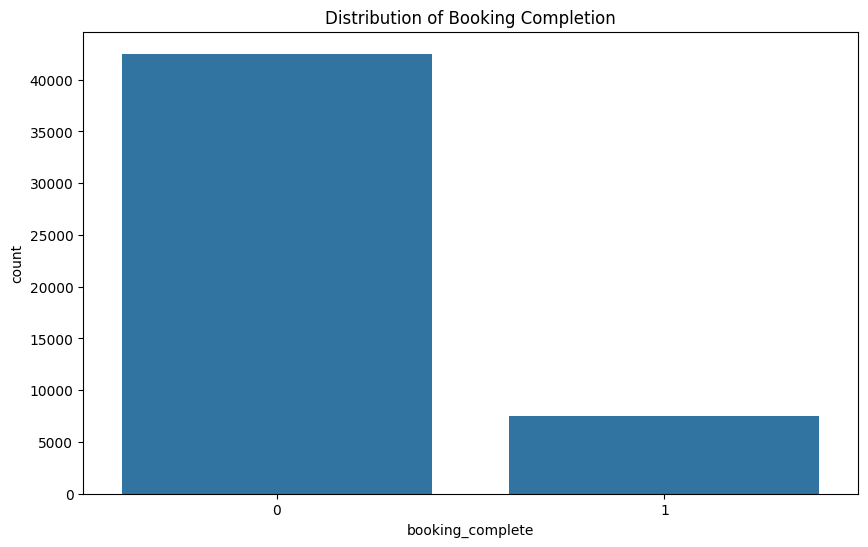

In [9]:
# Booking completion rate analysis
completion_rate = df['booking_complete'].mean() * 100
print(f"Overall booking completion rate: {completion_rate:.2f}%")

# Visualize booking completion distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='booking_complete')
plt.title('Distribution of Booking Completion')
plt.show()

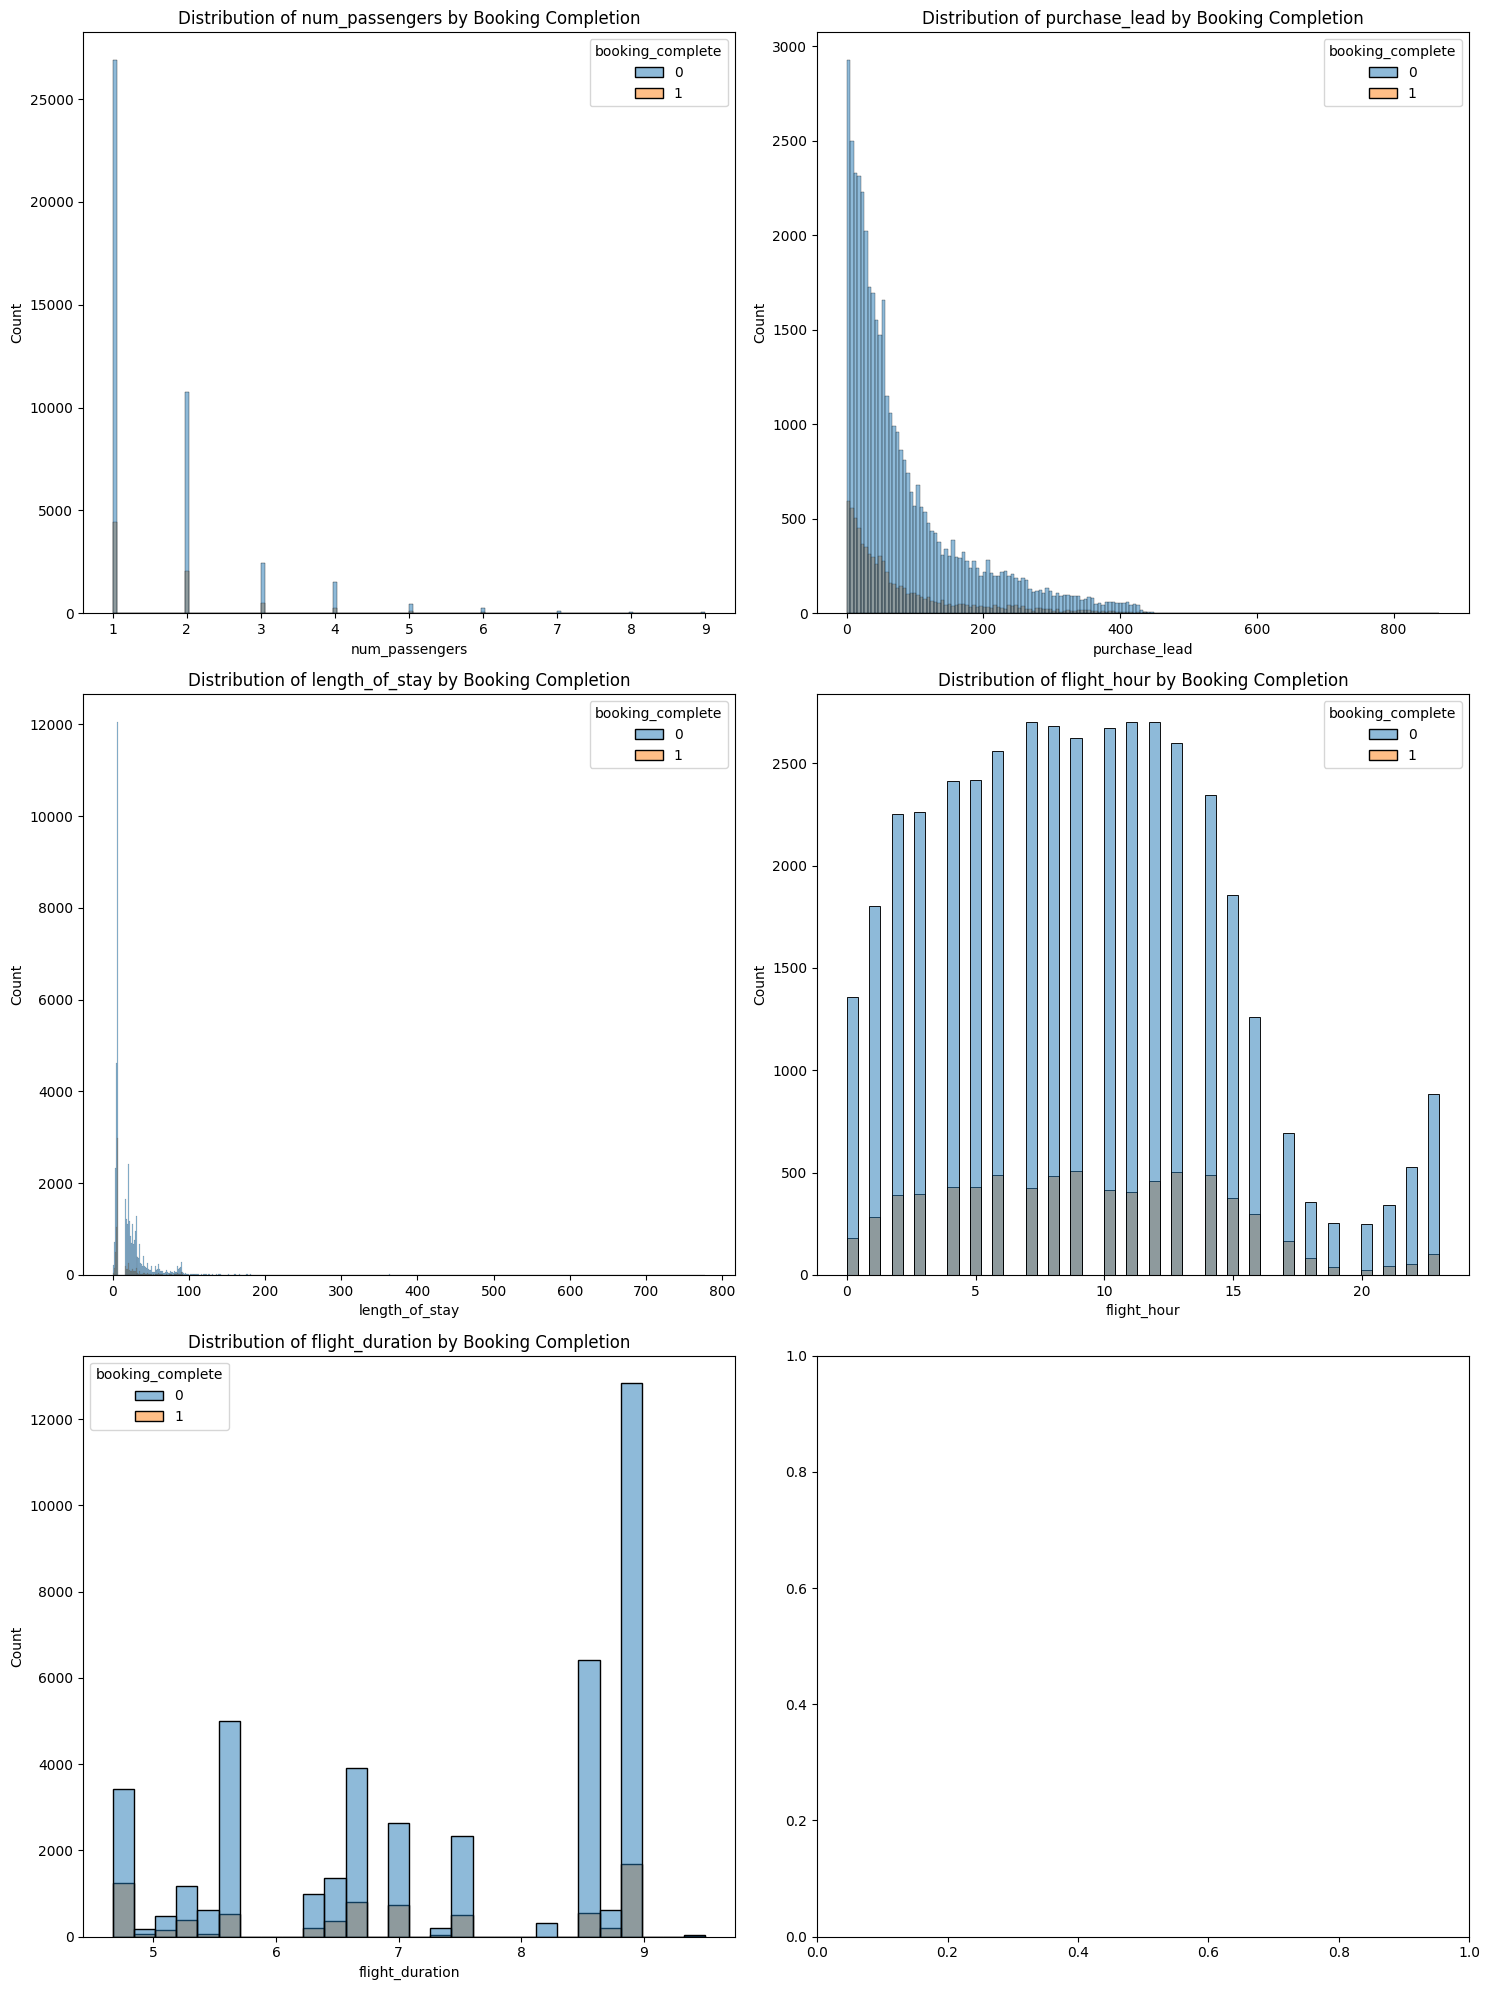

In [10]:
# Analyze numerical features distribution
numerical_cols = ['num_passengers', 'purchase_lead', 'length_of_stay',
                 'flight_hour', 'flight_duration']

fig, axes = plt.subplots(3, 2, figsize=(15, 20))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    # Distribution plot
    sns.histplot(data=df, x=col, hue='booking_complete',
                multiple="layer", ax=axes[idx])
    axes[idx].set_title(f'Distribution of {col} by Booking Completion')

plt.tight_layout()
plt.show()

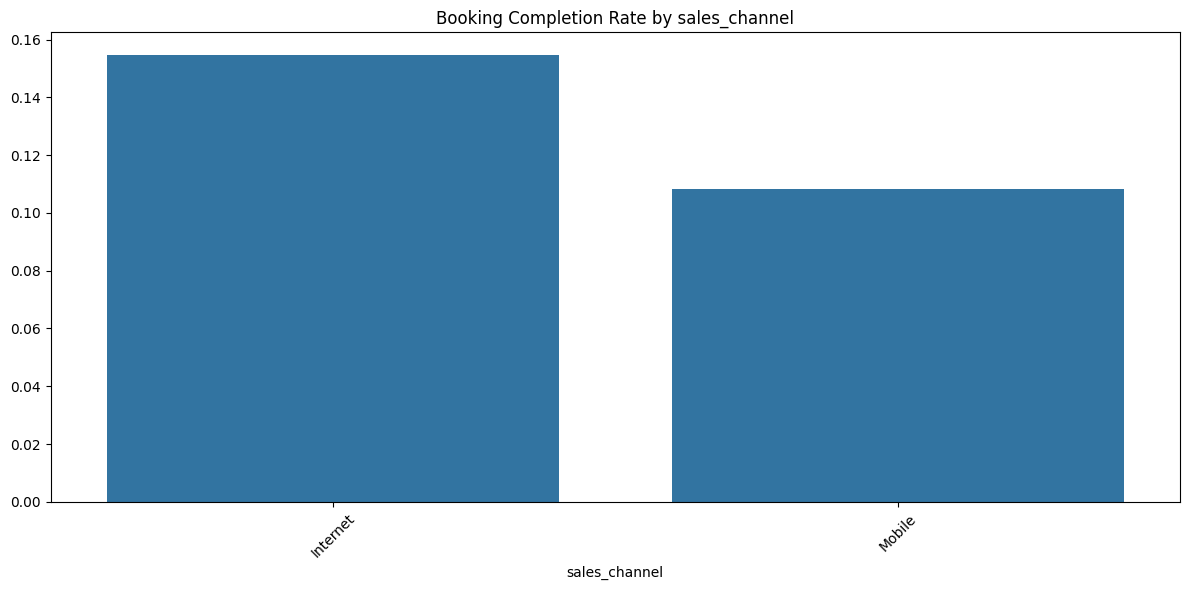


Value counts for sales_channel:
sales_channel
Internet    44382
Mobile       5618
Name: count, dtype: int64

Completion rates for sales_channel:
sales_channel
Internet    0.154770
Mobile      0.108402
Name: booking_complete, dtype: float64
--------------------------------------------------


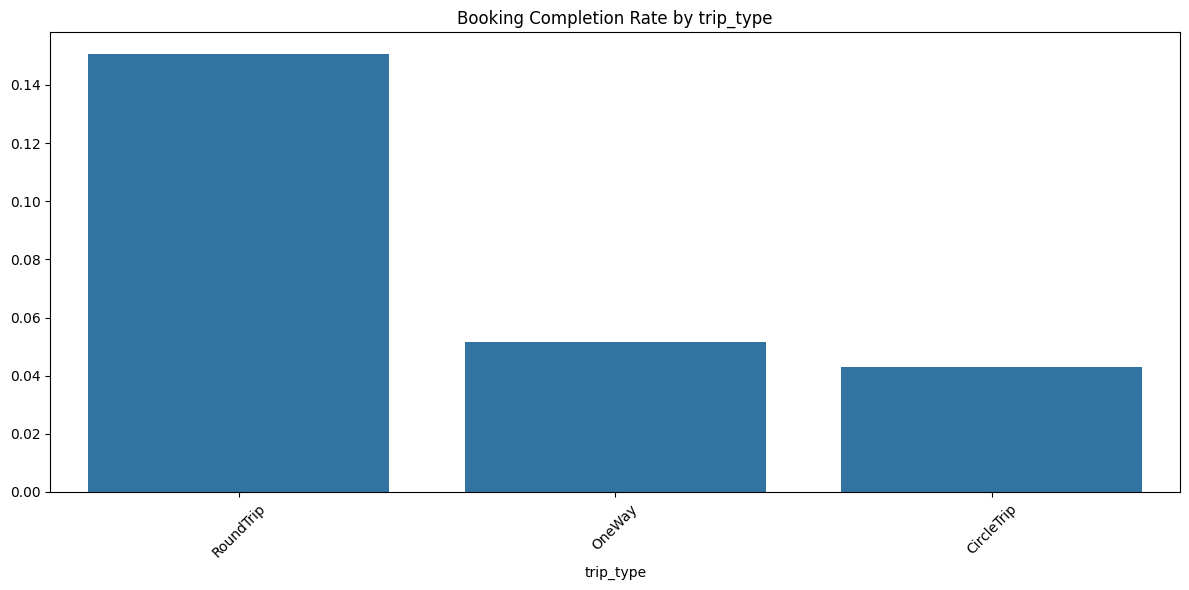


Value counts for trip_type:
trip_type
RoundTrip     49497
OneWay          387
CircleTrip      116
Name: count, dtype: int64

Completion rates for trip_type:
trip_type
RoundTrip     0.150575
OneWay        0.051680
CircleTrip    0.043103
Name: booking_complete, dtype: float64
--------------------------------------------------


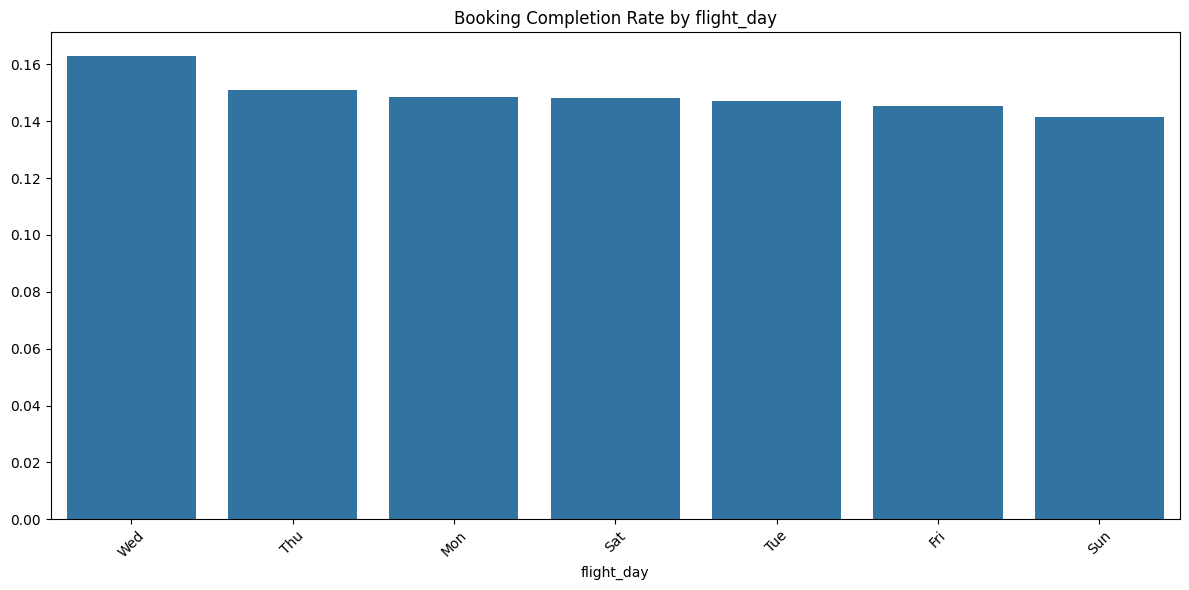


Value counts for flight_day:
flight_day
Mon    8102
Wed    7674
Tue    7673
Thu    7424
Fri    6761
Sun    6554
Sat    5812
Name: count, dtype: int64

Completion rates for flight_day:
flight_day
Wed    0.163148
Thu    0.151131
Mon    0.148605
Sat    0.148142
Tue    0.147139
Fri    0.145393
Sun    0.141440
Name: booking_complete, dtype: float64
--------------------------------------------------


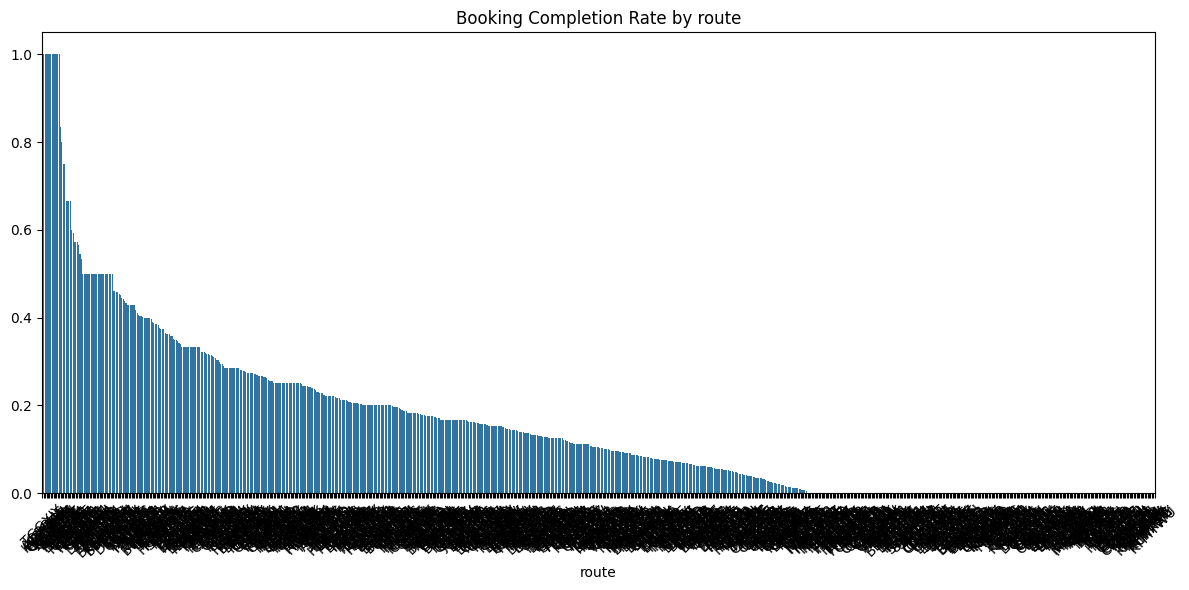


Value counts for route:
route
AKLKUL    2680
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
          ... 
AKLHGH       1
MELVTE       1
MELWUH       1
URTXIY       1
MRUXIY       1
Name: count, Length: 799, dtype: int64

Completion rates for route:
route
TGGXIY    1.0
AORPUS    1.0
KCHMRU    1.0
HDYOOL    1.0
AORPER    1.0
         ... 
KTMSYD    0.0
KTMTGG    0.0
KTMTPE    0.0
KTMTWU    0.0
CNXXIY    0.0
Name: booking_complete, Length: 799, dtype: float64
--------------------------------------------------


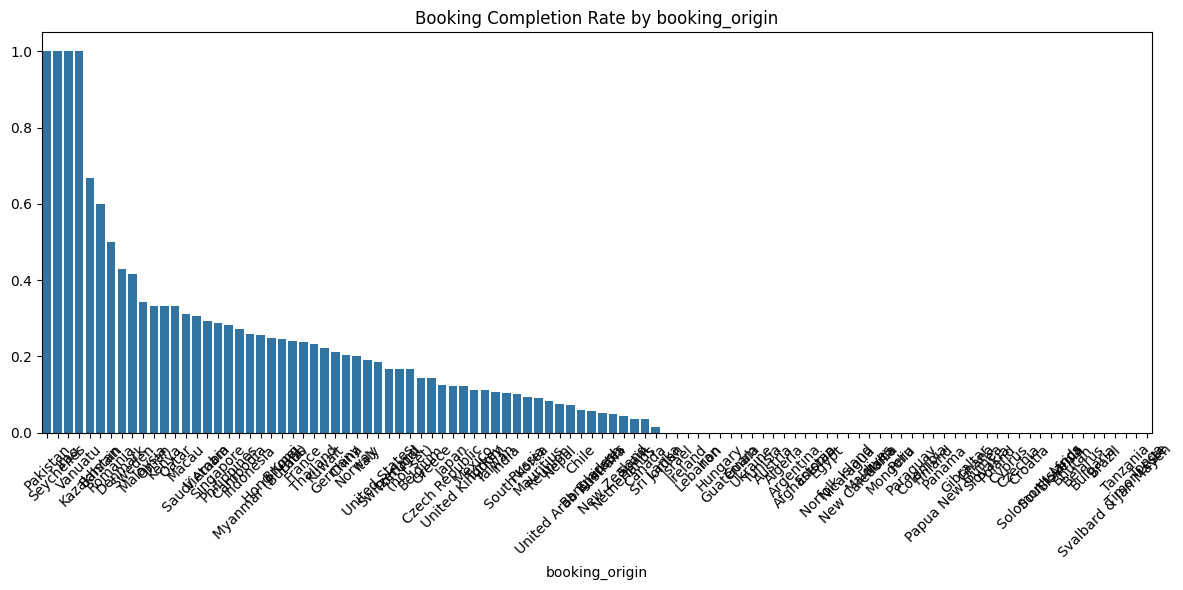


Value counts for booking_origin:
booking_origin
Australia      17872
Malaysia        7174
South Korea     4559
Japan           3885
China           3387
               ...  
Estonia            1
Afghanistan        1
Czechia            1
Malta              1
Vanuatu            1
Name: count, Length: 104, dtype: int64

Completion rates for booking_origin:
booking_origin
Pakistan                1.000000
Seychelles              1.000000
Iraq                    1.000000
Vanuatu                 1.000000
Kazakhstan              0.666667
                          ...   
Brazil                  0.000000
Svalbard & Jan Mayen    0.000000
Tanzania                0.000000
Timor-Leste             0.000000
Tonga                   0.000000
Name: booking_complete, Length: 104, dtype: float64
--------------------------------------------------


In [11]:
# Analyze categorical features
categorical_cols = ['sales_channel', 'trip_type', 'flight_day',
                   'route', 'booking_origin']

# Create completion rate by categorical features
for col in categorical_cols:
    plt.figure(figsize=(12, 6))
    completion_rates = df.groupby(col)['booking_complete'].mean().sort_values(ascending=False)

    sns.barplot(x=completion_rates.index, y=completion_rates.values)
    plt.title(f'Booking Completion Rate by {col}')
    plt.xticks(rotation=45)
    plt.savefig(f'Booking Completion Rate by {col}', bbox_inches='tight')
    plt.tight_layout()
    plt.show()

    # Print value counts and completion rates
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts())
    print(f"\nCompletion rates for {col}:")
    print(completion_rates)
    print("-"*50)

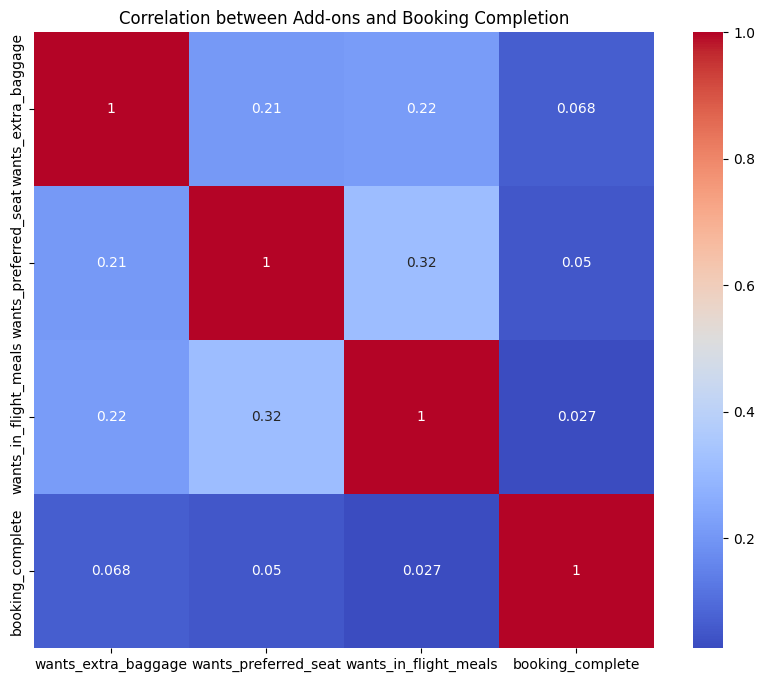

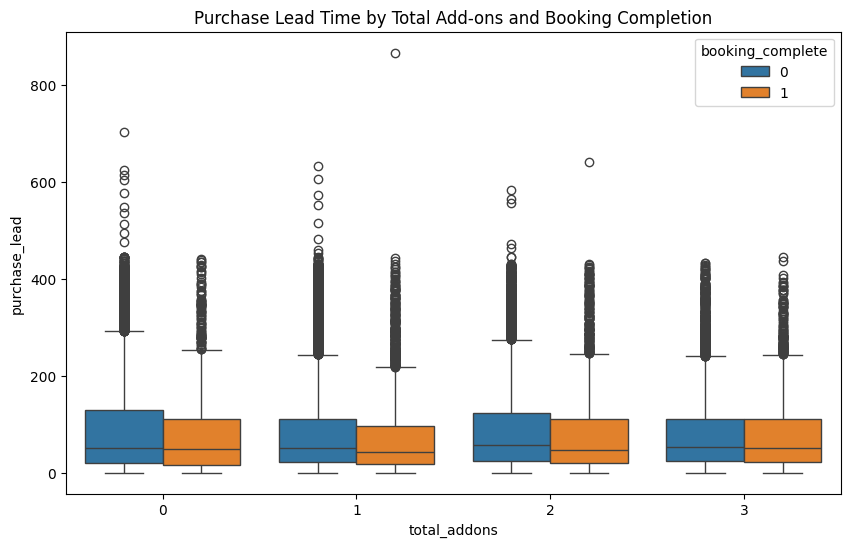

In [12]:
# Analyze add-on preferences
addon_cols = ['wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']

# Create correlation matrix for add-ons
plt.figure(figsize=(10, 8))
sns.heatmap(df[addon_cols + ['booking_complete']].corr(),
            annot=True, cmap='coolwarm')
plt.title('Correlation between Add-ons and Booking Completion')
plt.show()

# Analyze combined add-on effect
df['total_addons'] = df[addon_cols].sum(axis=1)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='total_addons', y='purchase_lead', hue='booking_complete')
plt.title('Purchase Lead Time by Total Add-ons and Booking Completion')
plt.show()

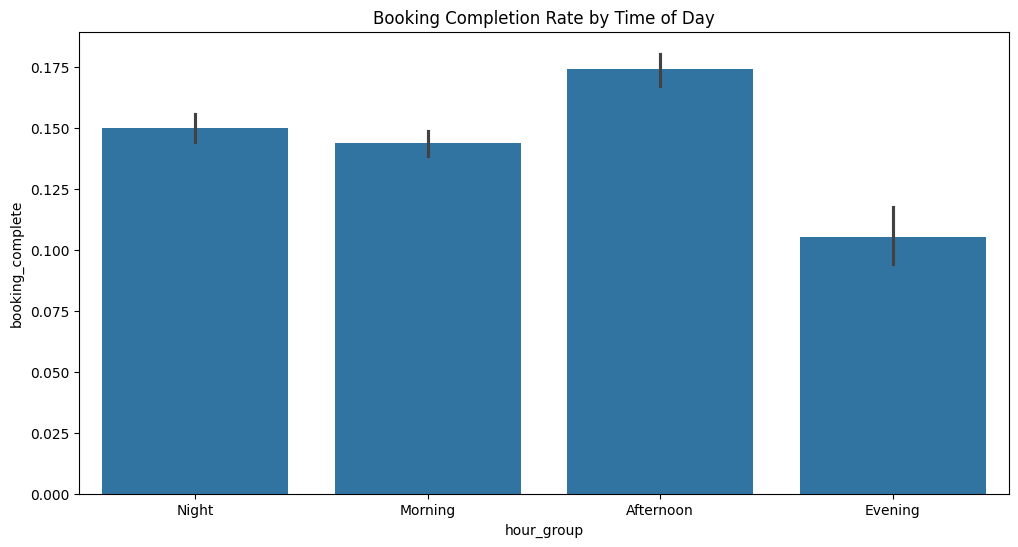

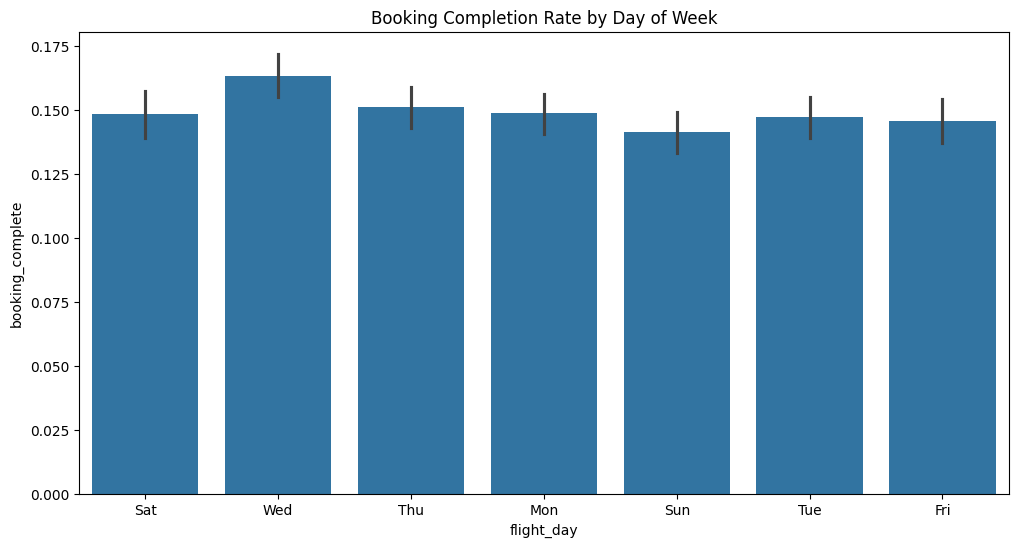

In [13]:
# Time-based analysis
# Create hour groups
df['hour_group'] = pd.cut(df['flight_hour'],
                         bins=[0, 6, 12, 18, 24],
                         labels=['Night', 'Morning', 'Afternoon', 'Evening'])

# Analyze booking patterns by time
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='hour_group', y='booking_complete')
plt.title('Booking Completion Rate by Time of Day')
plt.show()

# Analyze day of week patterns
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='flight_day', y='booking_complete')
plt.title('Booking Completion Rate by Day of Week')
plt.show()

In [14]:
# Feature Engineering

In [15]:
# Create a copy to avoid modifying the original dataframe
df_processed = df.copy()

In [16]:
df_processed["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [17]:
# Convert flight_day to numeric
day_mapping = {
    "Mon": 1, "Tue": 2, "Wed": 3, "Thu": 4,
    "Fri": 5, "Sat": 6, "Sun": 7
}
df_processed['flight_day'] = df_processed['flight_day'].map(day_mapping)


In [18]:
df_processed["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [19]:
 # Create new features
# Time-based features
df_processed['is_weekend'] = df_processed['flight_day'].isin([6, 7]).astype(int)
df_processed['is_business_hours'] = ((df_processed['flight_hour'] >= 8) &
                                       (df_processed['flight_hour'] <= 18)).astype(int)


In [20]:
 # Booking behavior features
df_processed['total_add_ons'] = (df_processed['wants_extra_baggage'] +
                                df_processed['wants_preferred_seat'] +
                                df_processed['wants_in_flight_meals'])


In [21]:
# Trip complexity score
df_processed['trip_complexity'] = (df_processed['length_of_stay'] *
                                    df_processed['num_passengers'])

In [22]:
 # Booking lead time categories
df_processed['lead_time_category'] = pd.cut(df_processed['purchase_lead'],
                                            bins=[0, 7, 30, 90, np.inf],
                                            labels=['last_minute', 'short_term',
                                                    'medium_term', 'long_term'])


In [23]:
 # Length of stay categories
df_processed['stay_duration_category'] = pd.cut(df_processed['length_of_stay'],
                                                bins=[0, 3, 7, 14, np.inf],
                                                labels=['short', 'week',
                                                        'fortnight', 'extended'])


In [24]:
# Encode categorical variables
categorical_columns = ['sales_channel', 'trip_type', 'route',
                        'booking_origin', 'hour_group','lead_time_category',
                        'stay_duration_category']


In [25]:
for col in categorical_columns:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col])

In [26]:
df_processed.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,...,flight_duration,booking_complete,total_addons,hour_group,is_weekend,is_business_hours,total_add_ons,trip_complexity,lead_time_category,stay_duration_category
0,2,0,2,262,19,7,6,0,61,1,...,5.52,0,1,2,1,0,1,38,1,0
1,1,0,2,112,20,3,6,0,61,0,...,5.52,0,0,3,1,0,0,20,1,0
2,2,0,2,243,22,17,3,0,36,1,...,5.52,0,2,0,0,1,2,44,1,0
3,1,0,2,96,31,4,6,0,61,0,...,5.52,0,1,3,1,0,1,31,1,0
4,2,0,2,68,22,15,3,0,36,1,...,5.52,0,2,0,0,1,2,44,2,0


In [27]:
# Model Training and Evaluation

In [28]:
# Separate features and target
features = df_processed.drop(['booking_complete'], axis=1)
target = df_processed['booking_complete']

In [29]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

In [30]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [31]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [32]:
# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5,
                            scoring='roc_auc')
print("\nCross-validation ROC-AUC scores:", cv_scores)
print("Mean CV ROC-AUC: {:.3f} (+/- {:.3f})".format(
    cv_scores.mean(), cv_scores.std() * 2))


Cross-validation ROC-AUC scores: [0.73351396 0.75009844 0.7356693  0.7373788  0.77024338]
Mean CV ROC-AUC: 0.745 (+/- 0.027)


In [33]:
# Make predictions on test set
y_pred = rf_model.predict(X_test_scaled)

In [34]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      8520
           1       0.55      0.09      0.15      1480

    accuracy                           0.85     10000
   macro avg       0.71      0.54      0.54     10000
weighted avg       0.82      0.85      0.81     10000



In [35]:
# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test_scaled)[:, 1])
print("\nTest Set ROC-AUC Score:", roc_auc)



Test Set ROC-AUC Score: 0.7593968880852684


In [36]:
# Feature Importance Visualization

In [37]:
# Get feature importance
importance = rf_model.feature_importances_

In [38]:
# After creating your features DataFrame
feature_names = features.columns.tolist()

In [39]:
# Create DataFrame for visualization
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
})

In [40]:
# Sort by importance
feature_importance = feature_importance.sort_values(
    'importance', ascending=False
)

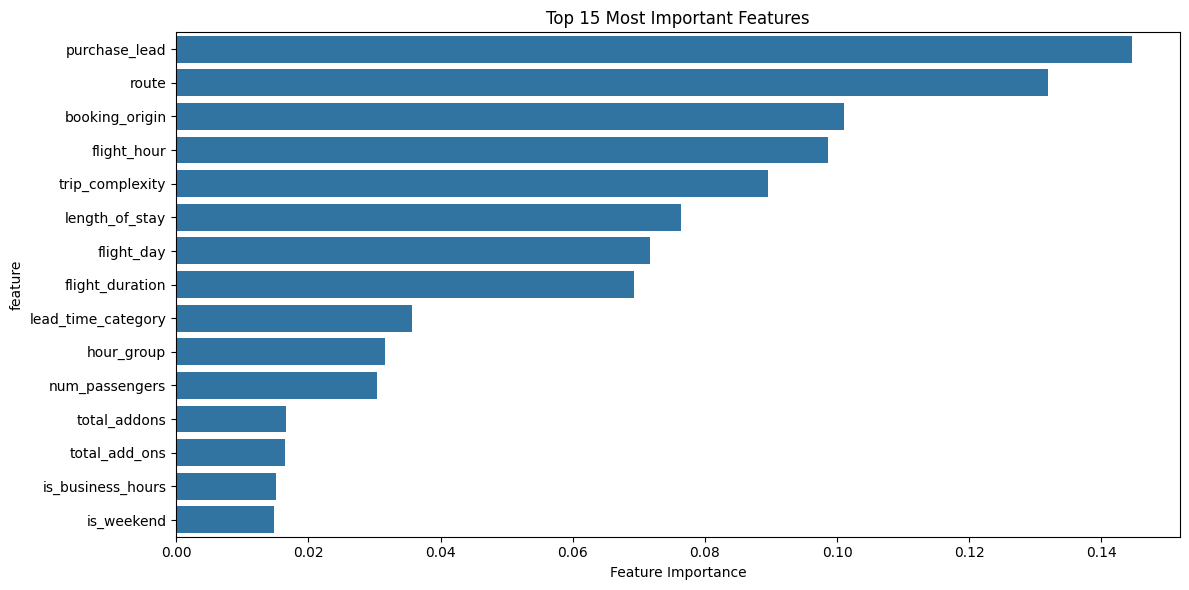

In [41]:
# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features')
plt.xlabel('Feature Importance')
plt.savefig('features.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

In [42]:
# SHAP Values Analysis

<Figure size 1200x800 with 0 Axes>

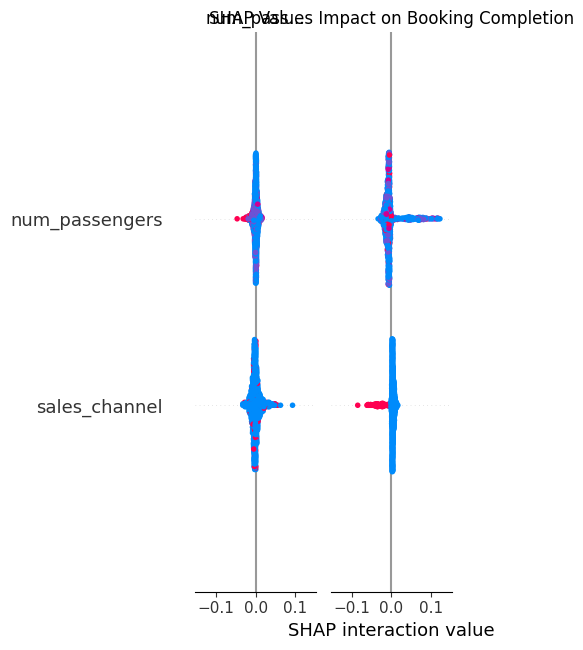

In [43]:

# 1. Ensure consistent feature names
# feature_names = np.array(features.columns.tolist())  # Convert to numpy array
# Ensure feature_names is a numpy array
feature_names = features.columns.to_numpy()  # Use pandas method for clarity

# 2. Create explainer with proper sample
sample_size = 1000
sample_indices = np.random.choice(X_test_scaled.shape[0], sample_size, replace=False)
X_test_sample = pd.DataFrame(X_test_scaled[sample_indices], columns=feature_names)  # Convert to DataFrame

# 3. Calculate SHAP values with proper handling
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_sample)

# 4. Create summary plot with proper shape handling
plt.figure(figsize=(12, 8))
if isinstance(shap_values, list):
    shap.summary_plot(
        shap_values[1],
        X_test_sample,
        feature_names=feature_names,  # Pass as numpy array, not .tolist()
        show=False
    )
else:
    shap.summary_plot(
        shap_values,
        X_test_sample,
        feature_names=feature_names,  # Pass as numpy array
        show=False
    )
plt.title('SHAP Values Impact on Booking Completion')
plt.tight_layout()
plt.show()

TypeError: only integer scalar arrays can be converted to a scalar index

<Figure size 1000x600 with 0 Axes>

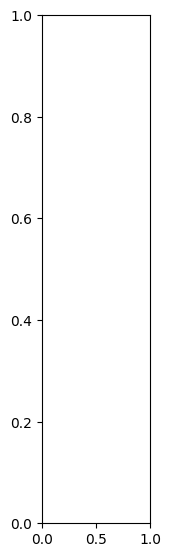

In [44]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import shap

# 1. Prepare the data
# Use only top 5 features
top_features = ['purchase_lead', 'route', 'booking_origin', 'flight_hour', 'trip_complexity']
X_train_top = pd.DataFrame(X_train_scaled, columns=feature_names)[top_features]
X_test_top = pd.DataFrame(X_test_scaled, columns=feature_names)[top_features]

# 2. Sample selection
sample_size = 1000
sample_indices = np.random.choice(len(X_test_top), sample_size, replace=False)
X_sample = X_test_top.iloc[sample_indices]
y_sample = y_test.iloc[sample_indices]

# 3. Train model on full dataset but using only top features
rf_model_top = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_top.fit(X_train_top, y_train)

# 4. Create explainer and calculate SHAP values
explainer = shap.TreeExplainer(rf_model_top)
shap_values = explainer.shap_values(X_sample)

# 5. Create SHAP summary plot
plt.figure(figsize=(10, 6))
if isinstance(shap_values, list):
    # For binary classification, use the second class's SHAP values
    shap.summary_plot(
        shap_values[1],
        X_sample,
        feature_names=top_features,
        show=False
    )
else:
    # For single output
    shap.summary_plot(
        shap_values,
        X_sample,
        feature_names=top_features,
        show=False
    )
plt.title("SHAP Summary Plot for Top 5 Features")
plt.tight_layout()
plt.show()

# 6. Create individual SHAP dependence plots
for feature in top_features:
    plt.figure(figsize=(10, 6))
    feature_idx = top_features.index(feature)
    if isinstance(shap_values, list):
        shap.dependence_plot(
            feature_idx,
            shap_values[1],
            X_sample,
            feature_names=top_features,
            show=False
        )
    else:
        shap.dependence_plot(
            feature_idx,
            shap_values,
            X_sample,
            feature_names=top_features,
            show=False
        )
    plt.title(f'SHAP Dependence Plot: {feature}')
    plt.tight_layout()
    plt.show()

In [ ]:
# 1. Select only the top 5 important features
top_features = ['purchase_lead', 'route', 'booking_origin',
               'flight_hour', 'trip_complexity']

# 2. Subset your data to only these features
X_train_top = X_train_scaled[:, [feature_names.tolist().index(f) for f in top_features]]
X_test_top = X_test_scaled[:, [feature_names.tolist().index(f) for f in top_features]]

# 3. Create a new random forest model (optional but recommended)
# This ensures model is trained only on top features
rf_model_top = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_top.fit(X_train_top, y_train)

# 4. Prepare 1000 sample data (use same indices for X and y)
sample_size = 1000
sample_indices = np.random.choice(X_test_top.shape[0], sample_size, replace=False)
X_sample = X_test_top[sample_indices]

# 5. Calculate SHAP values correctly
explainer = shap.TreeExplainer(rf_model_top)
shap_values = explainer.shap_values(X_sample)

# 6. Create SHAP visualizations
# A. Summary plot for top features
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values[1],
    X_sample,
    feature_names=top_features,
    max_display=5,
    show=False
)
plt.title("Top 5 Features Impacting Booking Completion (SHAP)")
plt.tight_layout()
plt.show()

# B. Dependence plots for each top feature
for feature in top_features:
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(
        top_features.index(feature),  # Use feature index
        shap_values[1],
        X_sample,
        feature_names=top_features,
        interaction_index=None
    )
    plt.title(f'SHAP Dependence Plot: {feature}')
    plt.tight_layout()
    plt.show()